In [1]:
# Project Requirements
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# -------------------------------------------------------
# Set a fixed random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# File paths
CSV_PATH = "healthcare_dataset.csv"   # Your dataset
TRAIN_PATH = "train_healthcare.csv"
TEST_PATH = "test_healthcare.csv"

# -------------------------------------------------------
# Function: Preprocess Healthcare Dataset
# -------------------------------------------------------
def preprocess_medical_data(df):
    df = df.copy()
    
    # Fill NaNs with empty strings
    df = df.fillna("")
    
    # Clean patient names (title case)
    df["Name"] = df["Name"].astype(str).str.title()
    
    # Clean hospital names (remove trailing commas & extra spaces)
    df["Hospital"] = (
        df["Hospital"].astype(str)
        .str.replace(r",+$", "", regex=True)
        .str.strip()
    )
    
    # Standardize Test Results
    df["Test Results"] = (
        df["Test Results"]
        .astype(str)
        .str.lower()
        .replace({"abnormal sample data": "abnormal"})
        .str.title()
    )
    
    # Round billing amounts
    df["Billing Amount"] = (
        pd.to_numeric(df["Billing Amount"], errors="coerce")
        .round(2)
    )
    
    # Convert dates and calculate Length of Stay
    df["Date of Admission"] = pd.to_datetime(df["Date of Admission"], errors="coerce")
    df["Discharge Date"] = pd.to_datetime(df["Discharge Date"], errors="coerce")
    df["Length of Stay"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days
    
    # Build text_for_nlp column
    df["text_for_nlp"] = (
        "Patient " + df["Name"].astype(str) +
        ", Age " + df["Age"].astype(str) +
        ", Gender " + df["Gender"].astype(str) +
        ", Blood Type " + df["Blood Type"].astype(str) +
        ", Condition: " + df["Medical Condition"].astype(str) +
        ". Doctor: " + df["Doctor"].astype(str) +
        ". Hospital: " + df["Hospital"].astype(str) +
        ". Insurance: " + df["Insurance Provider"].astype(str) +
        ". Room Number: " + df["Room Number"].astype(str) +
        ". Admission Type: " + df["Admission Type"].astype(str) +
        ". Medication: " + df["Medication"].astype(str) +
        ". Test Results: " + df["Test Results"].astype(str) +
        ". Length of Stay: " + df["Length of Stay"].astype(str)
    ).str.lower()
    
    return df

# -------------------------------------------------------
# Main Script: Load, Preprocess, Split Data
# -------------------------------------------------------

# Step 1: Load dataset
if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")
else:
    raise FileNotFoundError(f"{CSV_PATH} not found. Please place your dataset in the folder.")

# Step 2: Preprocess the data
df = preprocess_medical_data(df)

# Step 3: Train-test split (80-20)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED, shuffle=True)

# Step 4: Save split datasets
train_df.to_csv(TRAIN_PATH, index=False)
test_df.to_csv(TEST_PATH, index=False)

# Final message
print(f"Data prepared: {len(train_df)} train, {len(test_df)} test.")

Loaded dataset: 55500 rows, 15 columns
Data prepared: 44400 train, 11100 test.


In [2]:
# -------------------------------------------------------
# TF-IDF Vectorization for Healthcare Dataset
# -------------------------------------------------------
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Paths for saving the trained vectorizer and TF-IDF matrix
MODEL_PATH = "healthcare_vectorizer.pkl"
MATRIX_PATH = "healthcare_tfidf_matrix.pkl"

# -------------------------------------------------------
# Step 1: Load datasets
# -------------------------------------------------------
# Training dataset (already split earlier)
train_df = pd.read_csv("train_healthcare.csv")

# Full dataset (all records, for final representation)
full_df = pd.read_csv("healthcare_dataset.csv")

# -------------------------------------------------------
# Step 2: Preprocessing function
# -------------------------------------------------------
def preprocess_medical_data(df):
    df = df.copy()
    df = df.fillna("")
    
    df["Name"] = df["Name"].astype(str).str.title()
    df["Hospital"] = df["Hospital"].astype(str).str.replace(r",+$", "", regex=True).str.strip()
    df["Test Results"] = (
        df["Test Results"]
        .astype(str)
        .str.lower()
        .replace({"abnormal sample data": "abnormal"})
        .str.title()
    )
    
    df["Billing Amount"] = pd.to_numeric(df["Billing Amount"], errors="coerce").round(2)
    df["Date of Admission"] = pd.to_datetime(df["Date of Admission"], errors="coerce")
    df["Discharge Date"] = pd.to_datetime(df["Discharge Date"], errors="coerce")
    df["Length of Stay"] = (df["Discharge Date"] - df["Date of Admission"]).dt.days
    
    # Build text_for_nlp column
    df["text_for_nlp"] = (
        "Patient " + df["Name"].astype(str) +
        ", Age " + df["Age"].astype(str) +
        ", Gender " + df["Gender"].astype(str) +
        ", Blood Type " + df["Blood Type"].astype(str) +
        ", Condition: " + df["Medical Condition"].astype(str) +
        ". Doctor: " + df["Doctor"].astype(str) +
        ". Hospital: " + df["Hospital"].astype(str) +
        ". Insurance: " + df["Insurance Provider"].astype(str) +
        ". Room Number: " + df["Room Number"].astype(str) +
        ". Admission Type: " + df["Admission Type"].astype(str) +
        ". Medication: " + df["Medication"].astype(str) +
        ". Test Results: " + df["Test Results"].astype(str) +
        ". Length of Stay: " + df["Length of Stay"].astype(str)
    ).str.lower()
    
    return df

# Apply preprocessing to both train and full datasets
train_df = preprocess_medical_data(train_df)
full_df = preprocess_medical_data(full_df)

# -------------------------------------------------------
# Step 3: Train TF-IDF Vectorizer
# -------------------------------------------------------
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Train vectorizer ONLY on training dataset
vectorizer.fit(train_df["text_for_nlp"])

# -------------------------------------------------------
# Step 4: Transform full dataset
# -------------------------------------------------------
tfidf_matrix = vectorizer.transform(full_df["text_for_nlp"])

# -------------------------------------------------------
# Step 5: Save model and results
# -------------------------------------------------------
joblib.dump(vectorizer, MODEL_PATH)
joblib.dump({"matrix": tfidf_matrix, "df": full_df}, MATRIX_PATH)

# -------------------------------------------------------
print(f"✅ Healthcare TF-IDF model saved to {MODEL_PATH} and {MATRIX_PATH}")

✅ Healthcare TF-IDF model saved to healthcare_vectorizer.pkl and healthcare_tfidf_matrix.pkl


TF-IDF matrix shape: (55500, 5000), Sparsity: 1.26%
Top 20 words/phrases by TF-IDF importance:
type: 3876.42
doctor: 1938.21
gender: 1938.21
admission: 1938.21
of stay: 1938.21
number: 1938.21
of: 1938.21
patient: 1938.21
results: 1938.21
stay: 1938.21
test: 1938.21
length of: 1938.21
test results: 1938.21
blood: 1938.21
blood type: 1938.21
insurance: 1938.21
condition: 1938.21
room: 1938.21
admission type: 1938.21
medication: 1938.21


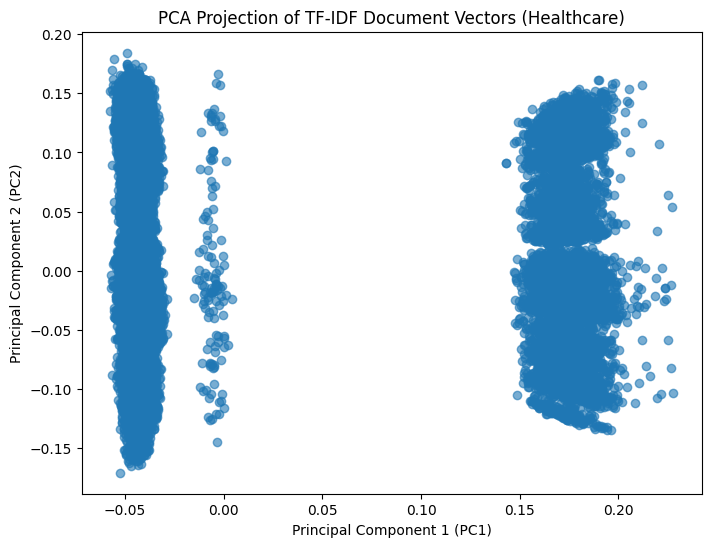

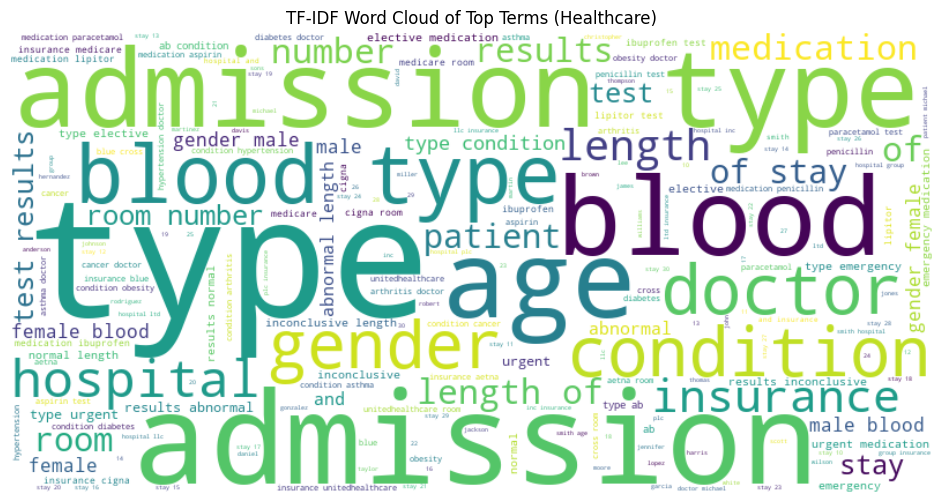

In [3]:
# -------------------------------------------------------
# TF-IDF Analysis & Visualization for Healthcare Dataset
# -------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import joblib

# -------------------------------------------------------
# Step 0: Load TF-IDF matrix and vectorizer
# -------------------------------------------------------
MATRIX_PATH = "healthcare_tfidf_matrix.pkl"
MODEL_PATH = "healthcare_vectorizer.pkl"

# Load saved TF-IDF matrix and full dataset
data = joblib.load(MATRIX_PATH)
tfidf_matrix = data["matrix"]
full_df = data["df"]

# Load trained vectorizer
vectorizer = joblib.load(MODEL_PATH)

# -------------------------------------------------------
# 1. Sparsity of TF-IDF matrix
# -------------------------------------------------------
sparsity = 100.0 * (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}, Sparsity: {sparsity:.2f}%")

# -------------------------------------------------------
# 2. Top 20 words/phrases by overall TF-IDF importance
# -------------------------------------------------------
feature_names = np.array(vectorizer.get_feature_names_out())
tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
top_indices = tfidf_sum.argsort()[::-1][:20]

print("Top 20 words/phrases by TF-IDF importance:")
for word, score in zip(feature_names[top_indices], tfidf_sum[top_indices]):
    print(f"{word}: {score:.2f}")

# -------------------------------------------------------
# 3. PCA projection of documents (2D)
# -------------------------------------------------------
pca = PCA(n_components=2)
reduced = pca.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.6)
plt.title("PCA Projection of TF-IDF Document Vectors (Healthcare)")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.show()

# -------------------------------------------------------
# 4. Word Cloud of Top Terms
# -------------------------------------------------------
top_words_dict = {feature_names[i]: tfidf_sum[i] for i in range(len(feature_names))}

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate_from_frequencies(top_words_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("TF-IDF Word Cloud of Top Terms (Healthcare)")
plt.show()

In [4]:
# -------------------------------------------------------
# Healthcare Patient/Record Search using TF-IDF & Cosine Similarity
# -------------------------------------------------------
import textwrap
import joblib
from sklearn.metrics.pairwise import cosine_similarity

# Paths to saved vectorizer and TF-IDF matrix
MODEL_PATH = "healthcare_vectorizer.pkl"
MATRIX_PATH = "healthcare_tfidf_matrix.pkl"

# -------------------------------------------------------
# Step 1: Load trained TF-IDF vectorizer
# -------------------------------------------------------
vectorizer = joblib.load(MODEL_PATH)

# -------------------------------------------------------
# Step 2: Load TF-IDF matrix and full dataset
# -------------------------------------------------------
data = joblib.load(MATRIX_PATH)
tfidf_matrix = data["matrix"]  # TF-IDF vectors of all patient records
df = data["df"]                # Full dataset with patient details

# -------------------------------------------------------
# Step 3: Define search function
# -------------------------------------------------------
def search_patient_records(query, top_k=3):
    """
    Returns the top_k patient records most similar to the query.
    - query: string containing user query
    - top_k: number of top results to return
    """
    # Convert query to TF-IDF vector
    query_vec = vectorizer.transform([query.lower()])

    # Compute cosine similarity between query and all patient records
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Get indices of top_k most similar records
    top_idx = sims.argsort()[::-1][:top_k]

    # Print results
    print(f"\n🔎 Query: {query}")
    for idx in top_idx:
        row = df.iloc[idx]
        snippet = textwrap.shorten(row["text_for_nlp"], width=250, placeholder="...")
        print(f"\n📌 Patient: {row['Name']} | Age: {row['Age']} | Gender: {row['Gender']} | Score={sims[idx]:.3f}")
        print(f"Condition: {row['Medical Condition']} | Doctor: {row['Doctor']} | Hospital: {row['Hospital']}")
        print(f"Record snippet: {snippet}")

# -------------------------------------------------------
# Step 4: Example usage
# -------------------------------------------------------
search_patient_records("diabetes treatment with insulin and monitoring", top_k=3)


🔎 Query: diabetes treatment with insulin and monitoring

📌 Patient: Javier Clark | Age: 51 | Gender: Male | Score=0.141
Condition: Diabetes | Doctor: Michael Anthony | Hospital: and Kim Sons
Record snippet: patient javier clark, age 51, gender male, blood type a+, condition: diabetes. doctor: michael anthony. hospital: and kim sons. insurance: cigna. room number: 313. admission type: emergency. medication: aspirin. test results: abnormal. length of...

📌 Patient: Savannah Navarro | Age: 64 | Gender: Female | Score=0.136
Condition: Diabetes | Doctor: Kristie Burgess | Hospital: Carey Davis, Turner and
Record snippet: patient savannah navarro, age 64, gender female, blood type a-, condition: diabetes. doctor: kristie burgess. hospital: carey davis, turner and. insurance: aetna. room number: 165. admission type: urgent. medication: ibuprofen. test results:...

📌 Patient: Kathleen Perez | Age: 16 | Gender: Male | Score=0.135
Condition: Diabetes | Doctor: Chelsey Jordan | Hospital: Sons Cr

In [5]:
# -------------------------------------------------------
# Healthcare Record Search using TF-IDF + Cosine Similarity
# -------------------------------------------------------
import joblib
from sklearn.metrics.pairwise import cosine_similarity

# --------------------------
# Step 1: Load saved TF-IDF vectorizer & matrix
# --------------------------
vectorizer = joblib.load("healthcare_vectorizer.pkl")   # TF-IDF model
data = joblib.load("healthcare_tfidf_matrix.pkl")       # Contains TF-IDF matrix + full dataset
tfidf_matrix = data["matrix"]                           # Sparse TF-IDF vectors
full_df = data["df"]                                    # Full healthcare dataset

# --------------------------
# Step 2: Query function
# --------------------------
def query_patient_records(question, top_k=3):
    """
    Returns the top_k matching patient records for a given query.

    Parameters:
    - question: str, user query
    - top_k: int, number of top results to return

    Returns:
    - List of dictionaries with patient details and similarity score
    """
    # Preprocess the query
    query_text = question.lower()

    # Vectorize the query using the trained TF-IDF model
    query_vec = vectorizer.transform([query_text])

    # Compute cosine similarity between query and all patient records
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Get indices of top_k most similar records
    top_indices = sims.argsort()[::-1][:top_k]

    # Collect results
    results = []
    for idx in top_indices:
        row = full_df.iloc[idx]
        results.append({
            "Name": row["Name"],
            "Age": row["Age"],
            "Gender": row["Gender"],
            "Medical Condition": row["Medical Condition"],
            "Doctor": row["Doctor"],
            "Hospital": row["Hospital"],
            "Similarity": float(sims[idx])
        })
    return results

# --------------------------
# Step 3: Demo usage
# --------------------------
question = "diabetes treatment with insulin and monitoring"
top_matches = query_patient_records(question, top_k=3)

# Print results in a readable format
for i, res in enumerate(top_matches, 1):
    print(f"{i}. {res['Name']} | Age: {res['Age']} | Gender: {res['Gender']}")
    print(f"   Condition: {res['Medical Condition']} | Doctor: {res['Doctor']} | Hospital: {res['Hospital']}")
    print(f"   Similarity Score: {res['Similarity']:.2f}\n")


1. Javier Clark | Age: 51 | Gender: Male
   Condition: Diabetes | Doctor: Michael Anthony | Hospital: and Kim Sons
   Similarity Score: 0.14

2. Savannah Navarro | Age: 64 | Gender: Female
   Condition: Diabetes | Doctor: Kristie Burgess | Hospital: Carey Davis, Turner and
   Similarity Score: 0.14

3. Kathleen Perez | Age: 16 | Gender: Male
   Condition: Diabetes | Doctor: Chelsey Jordan | Hospital: Sons Cruz and
   Similarity Score: 0.13



In [6]:
# -------------------------------------------------------
# Advanced Healthcare Record Search using TF-IDF + Cosine Similarity
# -------------------------------------------------------
import joblib
from sklearn.metrics.pairwise import cosine_similarity

# --------------------------
# Step 1: Load saved TF-IDF vectorizer & matrix
# --------------------------
vectorizer = joblib.load("healthcare_vectorizer.pkl")   # TF-IDF model
data = joblib.load("healthcare_tfidf_matrix.pkl")       # Contains TF-IDF matrix + full dataset
tfidf_matrix = data["matrix"]                           # Sparse TF-IDF vectors
full_df = data["df"]                                    # Full healthcare dataset

# --------------------------
# Step 2: Query function with filters
# --------------------------
def search_patient_records(query, top_k=5, condition=None, doctor=None, hospital=None):
    """
    Search patient records using TF-IDF similarity and optional filters.

    Parameters:
    - query: str, text query
    - top_k: int, number of results to return
    - condition: str, optional filter for Medical Condition
    - doctor: str, optional filter for Doctor
    - hospital: str, optional filter for Hospital

    Returns:
    - List of dicts with patient info and similarity scores
    """
    # Preprocess the query
    query_vec = vectorizer.transform([query.lower()])
    
    # Compute cosine similarity with all records
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    
    # Create a copy of dataframe with similarity scores
    df_copy = full_df.copy()
    df_copy["Similarity"] = sims
    
    # Apply optional filters
    if condition:
        df_copy = df_copy[df_copy["Medical Condition"].str.contains(condition, case=False, na=False)]
    if doctor:
        df_copy = df_copy[df_copy["Doctor"].str.contains(doctor, case=False, na=False)]
    if hospital:
        df_copy = df_copy[df_copy["Hospital"].str.contains(hospital, case=False, na=False)]
    
    # Get top_k results after filtering
    top_records = df_copy.sort_values(by="Similarity", ascending=False).head(top_k)
    
    # Prepare output
    results = []
    for _, row in top_records.iterrows():
        results.append({
            "Name": row["Name"],
            "Age": row["Age"],
            "Gender": row["Gender"],
            "Medical Condition": row["Medical Condition"],
            "Doctor": row["Doctor"],
            "Hospital": row["Hospital"],
            "Similarity": float(row["Similarity"])
        })
    
    return results

# --------------------------
# Step 3: Demo usage
# --------------------------
query = "diabetes treatment with insulin and monitoring"
top_matches = search_patient_records(query, top_k=5, condition="Diabetes", doctor="Matthew Smith")

# Print results
for i, res in enumerate(top_matches, 1):
    print(f"{i}. {res['Name']} | Age: {res['Age']} | Gender: {res['Gender']}")
    print(f"   Condition: {res['Medical Condition']} | Doctor: {res['Doctor']} | Hospital: {res['Hospital']}")
    print(f"   Similarity Score: {res['Similarity']:.2f}\n")


1. Ryan Holmes | Age: 50 | Gender: Male
   Condition: Diabetes | Doctor: Matthew Smith | Hospital: Parrish-Benitez
   Similarity Score: 0.08



In [7]:
# -------------------------------------------------------
# Healthcare Record Search with Highlighted Query Terms
# -------------------------------------------------------
import joblib
from sklearn.metrics.pairwise import cosine_similarity
import re
import textwrap

# --------------------------
# Step 1: Load saved TF-IDF vectorizer & matrix
# --------------------------
vectorizer = joblib.load("healthcare_vectorizer.pkl")
data = joblib.load("healthcare_tfidf_matrix.pkl")
tfidf_matrix = data["matrix"]
full_df = data["df"]

# --------------------------
# Step 2: Search function with optional filters and highlighting
# --------------------------
def search_patient_records_highlight(query, top_k=5, condition=None, doctor=None, hospital=None):
    """
    Search patient records and highlight query terms in the record snippet.

    Parameters:
    - query: str, text query
    - top_k: int, number of results to return
    - condition: str, optional filter for Medical Condition
    - doctor: str, optional filter for Doctor
    - hospital: str, optional filter for Hospital

    Returns:
    - List of dicts with patient info, similarity score, and highlighted snippet
    """
    query_vec = vectorizer.transform([query.lower()])
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    
    df_copy = full_df.copy()
    df_copy["Similarity"] = sims

    # Apply optional filters
    if condition:
        df_copy = df_copy[df_copy["Medical Condition"].str.contains(condition, case=False, na=False)]
    if doctor:
        df_copy = df_copy[df_copy["Doctor"].str.contains(doctor, case=False, na=False)]
    if hospital:
        df_copy = df_copy[df_copy["Hospital"].str.contains(hospital, case=False, na=False)]

    top_records = df_copy.sort_values(by="Similarity", ascending=False).head(top_k)

    results = []
    for _, row in top_records.iterrows():
        # Highlight query terms in text_for_nlp snippet
        snippet = row["text_for_nlp"]
        for term in query.lower().split():
            snippet = re.sub(f"({re.escape(term)})", r"**\1**", snippet, flags=re.IGNORECASE)
        snippet = textwrap.shorten(snippet, width=300, placeholder="...")
        
        results.append({
            "Name": row["Name"],
            "Age": row["Age"],
            "Gender": row["Gender"],
            "Medical Condition": row["Medical Condition"],
            "Doctor": row["Doctor"],
            "Hospital": row["Hospital"],
            "Similarity": float(row["Similarity"]),
            "Snippet": snippet
        })
    return results

# --------------------------
# Step 3: Demo usage
# --------------------------
query = "diabetes treatment insulin monitoring"
top_matches = search_patient_records_highlight(query, top_k=3, condition="Diabetes", doctor="Matthew Smith")

# Print results
for i, res in enumerate(top_matches, 1):
    print(f"{i}. {res['Name']} | Age: {res['Age']} | Gender: {res['Gender']}")
    print(f"   Condition: {res['Medical Condition']} | Doctor: {res['Doctor']} | Hospital: {res['Hospital']}")
    print(f"   Similarity Score: {res['Similarity']:.2f}")
    print(f"   Snippet: {res['Snippet']}\n")


1. Ryan Holmes | Age: 50 | Gender: Male
   Condition: Diabetes | Doctor: Matthew Smith | Hospital: Parrish-Benitez
   Similarity Score: 0.10
   Snippet: patient ryan holmes, age 50, gender male, blood type a-, condition: **diabetes**. doctor: matthew smith. hospital: parrish-benitez. insurance: unitedhealthcare. room number: 361. admission type: urgent. medication: ibuprofen. test results: inconclusive. length of stay: 6



In [1]:
# -------------------------------------------------------
# Interactive Healthcare Record Search with Highlighted Query Terms
# -------------------------------------------------------
import joblib
from sklearn.metrics.pairwise import cosine_similarity
import re
import textwrap

# --------------------------
# Step 1: Load saved TF-IDF vectorizer & matrix
# --------------------------
vectorizer = joblib.load("healthcare_vectorizer.pkl")
data = joblib.load("healthcare_tfidf_matrix.pkl")
tfidf_matrix = data["matrix"]
full_df = data["df"]

# --------------------------
# Step 2: Search function with highlighting and filters
# --------------------------
def search_patient_records_highlight(query, top_k=5, condition=None, doctor=None, hospital=None):
    query_vec = vectorizer.transform([query.lower()])
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    
    df_copy = full_df.copy()
    df_copy["Similarity"] = sims

    # Apply optional filters
    if condition:
        df_copy = df_copy[df_copy["Medical Condition"].str.contains(condition, case=False, na=False)]
    if doctor:
        df_copy = df_copy[df_copy["Doctor"].str.contains(doctor, case=False, na=False)]
    if hospital:
        df_copy = df_copy[df_copy["Hospital"].str.contains(hospital, case=False, na=False)]

    top_records = df_copy.sort_values(by="Similarity", ascending=False).head(top_k)

    results = []
    for _, row in top_records.iterrows():
        snippet = row["text_for_nlp"]
        for term in query.lower().split():
            snippet = re.sub(f"({re.escape(term)})", r"**\1**", snippet, flags=re.IGNORECASE)
        snippet = textwrap.shorten(snippet, width=300, placeholder="...")
        
        results.append({
            "Name": row["Name"],
            "Age": row["Age"],
            "Gender": row["Gender"],
            "Medical Condition": row["Medical Condition"],
            "Doctor": row["Doctor"],
            "Hospital": row["Hospital"],
            "Similarity": float(row["Similarity"]),
            "Snippet": snippet
        })
    return results

# --------------------------
# Step 3: Interactive input
# --------------------------
print("🔹 Welcome to Healthcare Record Search 🔹")
user_query = input("Enter your query (e.g., 'diabetes treatment insulin monitoring'): ")

# Optional filters
condition_filter = input("Filter by Medical Condition (leave blank for none): ") or None
doctor_filter = input("Filter by Doctor (leave blank for none): ") or None
hospital_filter = input("Filter by Hospital (leave blank for none): ") or None

# Run search
top_matches = search_patient_records_highlight(
    query=user_query,
    top_k=5,
    condition=condition_filter,
    doctor=doctor_filter,
    hospital=hospital_filter
)

# Display results
print("\n🔹 Top Matching Patient Records 🔹\n")
for i, res in enumerate(top_matches, 1):
    print(f"{i}. {res['Name']} | Age: {res['Age']} | Gender: {res['Gender']}")
    print(f"   Condition: {res['Medical Condition']} | Doctor: {res['Doctor']} | Hospital: {res['Hospital']}")
    print(f"   Similarity Score: {res['Similarity']:.2f}")
    print(f"   Snippet: {res['Snippet']}\n")

🔹 Welcome to Healthcare Record Search 🔹


Enter your query (e.g., 'diabetes treatment insulin monitoring'):  Dr. Kevin Wells diabetes patients
Filter by Medical Condition (leave blank for none):  
Filter by Doctor (leave blank for none):  
Filter by Hospital (leave blank for none):  



🔹 Top Matching Patient Records 🔹

1. Jessica Knox | Age: 22 | Gender: Male
   Condition: Diabetes | Doctor: Kevin Little | Hospital: and Chen, Wells Williams
   Similarity Score: 0.27
   Snippet: patient jessica knox, age 22, gender male, blood type b-, condition: **diabetes**. doctor: **kevin** little. hospital: and chen, **wells** williams. insurance: medicare. room number: 221. admission type: urgent. medication: ibuprofen. test results: normal. length of stay: 2

2. Kevin Weaver | Age: 60 | Gender: Male
   Condition: Diabetes | Doctor: Dr. Ryan Cross | Hospital: PLC Rasmussen
   Similarity Score: 0.24
   Snippet: patient **kevin** weaver, age 60, gender male, blood type o-, condition: **diabetes**. doctor: **dr.** ryan cross. hospital: plc rasmussen. insurance: unitedhealthcare. room number: 221. admission type: emergency. medication: paracetamol. test results: inconclusive. length of stay: 4

3. Dr. Kevin Hayden | Age: 25 | Gender: Male
   Condition: Diabetes | Doctor: Amber Bail